<a href="https://colab.research.google.com/github/daspartho/MagicMix/blob/main/MagicMIx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install diffusers transformers accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer, logging
import torch
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from PIL import Image
from IPython import display

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
tokenizer = CLIPTokenizer.from_pretrained(
    "openai/clip-vit-large-patch14",
)

text_encoder = CLIPTextModel.from_pretrained(
    "openai/clip-vit-large-patch14",
).to(device)

vae = AutoencoderKL.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder = "vae",
).to(device)

unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder = "unet",
).to(device)

beta_start,beta_end = 0.00085,0.012
scheduler = DDIMScheduler(
    beta_start=beta_start,
    beta_end=beta_end,
    beta_schedule="scaled_linear",
    num_train_timesteps=1000,
    clip_sample=False, 
    set_alpha_to_one=False,
)

In [4]:
def encode(img):
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(img).unsqueeze(0).to(device)*2-1)
        latent = 0.18215 * latent.latent_dist.sample()
    return latent

def decode(latent):
    latent = (1 / 0.18215) * latent
    with torch.no_grad():
        img = vae.decode(latent).sample
    img = (img / 2 + 0.5).clamp(0, 1)
    img = img.detach().cpu().permute(0, 2, 3, 1).numpy()
    img = (img * 255).round().astype("uint8")
    return Image.fromarray(img[0])

In [5]:
def prep_text(prompt):

    text_input = tokenizer(
        prompt,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )

    text_embedding = text_encoder(
        text_input.input_ids.to(device)
    )[0]

    uncond_input = tokenizer(
        "",
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )

    uncond_embedding = text_encoder(
        uncond_input.input_ids.to(device)
    )[0]

    return torch.cat([uncond_embedding, text_embedding])

In [6]:
def magic_mix(
    img,
    prompt,
    steps=50,
    kmin=15,
    kmax=30,
    v=0.5,
    seed=42,
    guidance_scale=7.5,
):

    tmin = steps-kmin
    tmax = steps-kmax

    text_embeddings = prep_text(prompt)

    scheduler.set_timesteps(steps)

    width, height = img.size
    encoded = encode(img)

    torch.manual_seed(seed)
    noise = torch.randn(
        (1,unet.in_channels,height // 8,width // 8),
    ).to(device)

    latents = scheduler.add_noise(
        encoded, 
        noise, 
        timesteps=scheduler.timesteps[tmax]
    )

    for i, t in enumerate(tqdm(scheduler.timesteps)):
        if i > tmax:
            if i < tmin:
                orig_latents = scheduler.add_noise(
                    encoded, 
                    noise, 
                    timesteps=t
                )
                
                input = (v*latents) + (1-v)*orig_latents
                input = torch.cat([input]*2)

            else:
                input = torch.cat([latents]*2)
                
            input = scheduler.scale_model_input(input, t)

            with torch.no_grad():
                pred = unet(
                    input, 
                    t,
                    encoder_hidden_states=text_embeddings,
                ).sample

            pred_uncond, pred_text = pred.chunk(2)
            pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

            latents = scheduler.step(pred, t, latents).prev_sample

    return decode(latents)

In [7]:
!curl --output test.jpg 'https://images.unsplash.com/photo-1523049673857-eb18f1d7b578?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1375&q=80'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 86548  100 86548    0     0   571k      0 --:--:-- --:--:-- --:--:--  574k


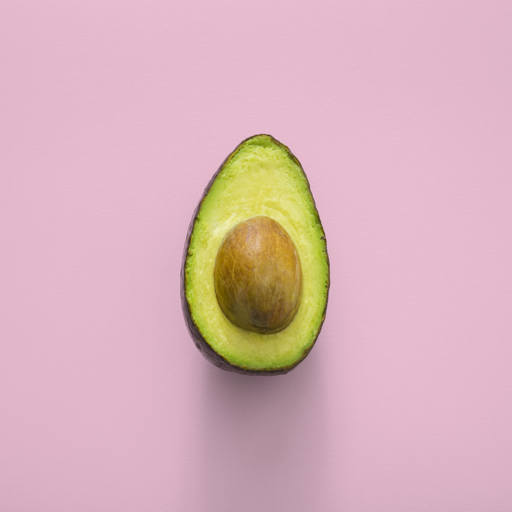

In [8]:
img = Image.open('test.jpg').resize((512, 512))
display.display(img)

  0%|          | 0/50 [00:00<?, ?it/s]

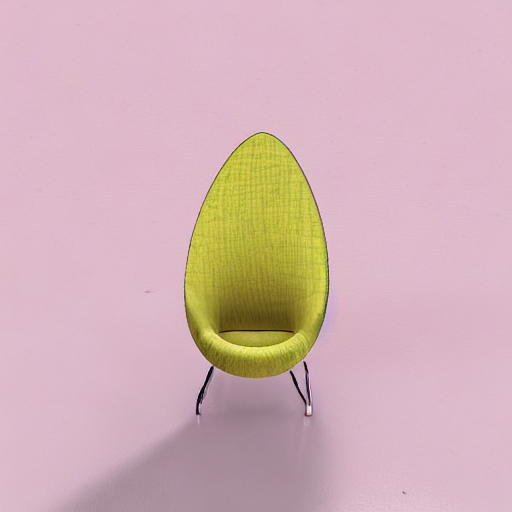

In [9]:
out_img = magic_mix(img, 'chair')
display.display(out_img)